In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
from scipy import stats
from scipy.stats import ttest_ind

In [3]:
import datetime as dt
from dateutil.parser import parse
from dateutil import rrule, parser
from datetime import datetime

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")
connection=engine.connect()

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)


# Exploratory Climate Analysis

## Precipitation Analysis

In [10]:
# My trip dates 2018-05-28 to 2018-06-03
startdate = '2017-05-28'
enddate = '2017-06-03'

In [11]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
#result=session.query(Measurement.date).order_by(Measurement.date.desc()).first()

# Calculate the date 1 year ago from the last data point in the database
result = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
#query_date = dt.date(2017,8,23)- dt.timedelta(days=365)
query_date = pd.to_datetime(result[0]) - dt.timedelta(days=365)
query_date=query_date.date()


# Perform a query to retrieve the data and precipitation scores
results = session.query(Measurement.id,Measurement.station, Measurement.date,Measurement.prcp,Measurement.tobs).\
    filter(Measurement.date >= query_date).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
prcp_data=pd.DataFrame(results,columns=['id','station','date','prcp','tobs'])
prcp_data=prcp_data.set_index('date')
prcp_data.head()

# Sort the dataframe by date
prcp_data=prcp_data.sort_values('date',ascending=False)
#prcp_data=prcp_data.set_index('date')
prcp_data.head()


,id,station,prcp,tobs
date,,,,
2017-08-23,19550,USC00516128,0.45,76.0
2017-08-23,12187,USC00519523,0.08,82.0
2017-08-23,7635,USC00514830,0.00,82.0
2017-08-23,2724,USC00519397,0.00,81.0
2017-08-22,12186,USC00519523,0.00,82.0


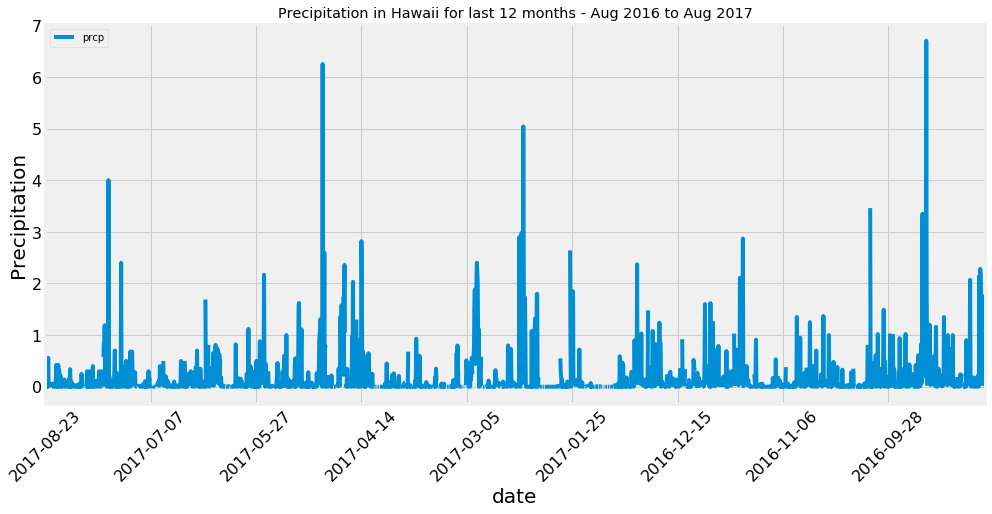

In [12]:
# Use Pandas Plotting with Matplotlib to plot the data
prcp_data.plot(y='prcp', figsize=(15, 7),                                             
               sort_columns=True, 
               rot=45, 
               use_index=True, 
               title='Precipitation in Hawaii for last 12 months - Aug 2016 to Aug 2017', 
               legend=True,
               
               fontsize=16,
               grid=True,
                             )

plt.xlabel('date', fontsize=20)
plt.ylabel('Precipitation', fontsize=20)
plt.show()

![precipitation](Images/precipitation.png)

## Precipitation Analysis- Alternate way to read data using pd.read_sql instead of session.query

In [13]:
# Read hawaii_measurements data
measurement_df=pd.read_sql('select * from measurement ',connection)
measurement_df['date'] = pd.to_datetime(measurement_df['date'])
#measurement_df['date']=measurement_df['date'].dt.date
measurement_df.head()


,id,station,date,prcp,tobs
0,1,USC00519397,2010-01-01,0.08,65.0
1,2,USC00519397,2010-01-02,0.00,63.0
2,3,USC00519397,2010-01-03,0.00,74.0
3,4,USC00519397,2010-01-04,0.00,76.0
4,5,USC00519397,2010-01-06,NaN,73.0


In [14]:
prcp_df = measurement_df[measurement_df["date"] >= query_date]
prcp_df=prcp_df.set_index('date')
prcp_df=prcp_df.sort_values('date',ascending=False)
prcp_df.head()

C:\Anaconda\envs\pythonData\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Comparing Series of datetimes with 'datetime.date'.  Currently, the
'datetime.date' is coerced to a datetime. In the future pandas will
not coerce, and a TypeError will be raised. To retain the current
behavior, convert the 'datetime.date' to a datetime with
'pd.Timestamp'.
  """Entry point for launching an IPython kernel.


,id,station,prcp,tobs
date,,,,
2017-08-23,19550,USC00516128,0.45,76.0
2017-08-23,12187,USC00519523,0.08,82.0
2017-08-23,7635,USC00514830,0.00,82.0
2017-08-23,2724,USC00519397,0.00,81.0
2017-08-22,12186,USC00519523,0.00,82.0


In [15]:
# Read station data
station_df=pd.read_sql('select * from station ',connection)
station_df.head()

,id,station,name,latitude,longitude,elevation
0,1,USC00519397,"WAIKIKI 717.2, HI US",21.2716,-157.8168,3.0
1,2,USC00513117,"KANEOHE 838.1, HI US",21.4234,-157.8015,14.6
2,3,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.5213,-157.8374,7.0
3,4,USC00517948,"PEARL CITY, HI US",21.3934,-157.9751,11.9
4,5,USC00518838,"UPPER WAHIAWA 874.3, HI US",21.4992,-158.0111,306.6


### Precipitation Stats

In [16]:
# Use Pandas to calcualte the summary statistics for the precipitation data
prcp_stats=prcp_data['prcp'].describe()
pd.DataFrame(prcp_stats)

,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


![describe](Images/describe.png)

## Station Analysis

In [17]:
# Design a query to show how many stations are available in this dataset?
stn_count=session.query(Measurement.station).distinct().count()
print (f"The total number of stations in Huwaii is {stn_count}")
#session.query(Measurement.station).distinct().all()


The total number of stations in Huwaii is 9


In [18]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
active_stn=session.query(Measurement.station,func.count(Measurement.station)).\
group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()
type(active_stn)
print (f" The active station list in descending order is ")
active_stn

 The active station list in descending order is 


[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [19]:

# extracts station with most activity
most_active_station=active_stn[0].station
print (f"The most active station is {most_active_station}")

The most active station is USC00519281


In [20]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
session.query(Measurement.station,
            func.min(Measurement.tobs),
            func.max(Measurement.tobs),
            func.avg(Measurement.tobs)).filter(Measurement.station==most_active_station).all()


[('USC00519281', 54.0, 85.0, 71.66378066378067)]

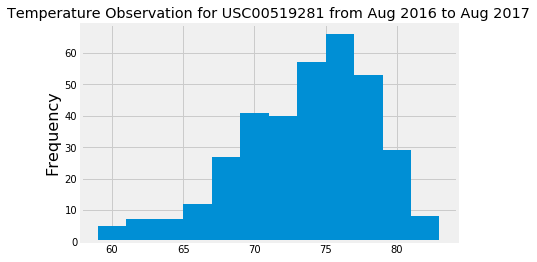

,id,station,prcp,tobs
date,,,,
2016-08-23,14608,USC00519281,1.79,77.0
2016-08-24,14609,USC00519281,2.15,77.0
2016-08-25,14610,USC00519281,0.06,80.0
2016-08-26,14611,USC00519281,0.01,80.0
2016-08-27,14612,USC00519281,0.12,75.0


In [21]:
# Choose the station with the highest number of temperature observations.

# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
tobs = session.query(Measurement.id,Measurement.station, Measurement.date,Measurement.prcp,Measurement.tobs).\
    filter(Measurement.date >= query_date).filter(Measurement.station==most_active_station).all()
tobs_df=pd.DataFrame(tobs,columns=['id','station','date','prcp','tobs'])
tobs_df=tobs_df.set_index('date')
tobs_df['tobs'].hist(bins=12)
tobs_df.head()
plt.title("Temperature Observation for %s from Aug 2016 to Aug 2017" % (most_active_station))
plt.ylabel('Frequency', fontsize=16)

plt.show()
tobs_df.head()

# Bonus

## Temperature Analysis I - T Test

In [22]:
measurement_df.head()

,id,station,date,prcp,tobs
0,1,USC00519397,2010-01-01,0.08,65.0
1,2,USC00519397,2010-01-02,0.00,63.0
2,3,USC00519397,2010-01-03,0.00,74.0
3,4,USC00519397,2010-01-04,0.00,76.0
4,5,USC00519397,2010-01-06,NaN,73.0


In [23]:
# Hawaii is reputed to enjoy mild weather all year. Is there a meaningful difference between the temperature in, for example, June and December?
# use main dataframe - measurement_df for this analysis
measurement_df.head()
# Identify the average temperature in Dec at all stations across all available years in the dataset.

dec_prcp=measurement_df[measurement_df["date"].dt.month == 12]
dec_avg=dec_prcp["tobs"].mean()
dec_avg
dec_prcp.head()

,id,station,date,prcp,tobs
305,306,USC00519397,2010-12-01,0.04,76.0
306,307,USC00519397,2010-12-03,0.00,74.0
307,308,USC00519397,2010-12-04,0.00,74.0
308,309,USC00519397,2010-12-06,0.00,64.0
309,310,USC00519397,2010-12-07,0.00,64.0


In [24]:
#Identify the average temperature in June at all stations across all available years in the dataset. 
jun_prcp=measurement_df[measurement_df["date"].dt.month == 6]
jun_avg=jun_prcp["tobs"].mean()
jun_avg
jun_prcp.head()

,id,station,date,prcp,tobs
133,134,USC00519397,2010-06-01,0.00,78.0
134,135,USC00519397,2010-06-02,0.01,76.0
135,136,USC00519397,2010-06-03,0.00,78.0
136,137,USC00519397,2010-06-04,0.00,76.0
137,138,USC00519397,2010-06-05,0.00,77.0


In [25]:
# Print June and Dec averages for reference
print(jun_avg)
print(dec_avg)

74.94411764705882
71.04152933421226


In [26]:
#Independent T Test
 # Null H (Hawaii is reputed to enjoy mild weather all year)
 # Alternate H ( Weather in Huwaii is different through the year)
ttest_ind(jun_prcp['tobs'], dec_prcp['tobs'])

# (pVal < 0.05 , hence rejecting Null H. Thus,Weather in Huwaii is different through the year)

Ttest_indResult(statistic=31.60372399000329, pvalue=3.9025129038616655e-191)

In [27]:
#stats.ttest_rel(jun_prcp['tobs'], dec_prcp['tobs'])

## Temperature Analysis II - My Trip Analysis 

In [28]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [29]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
# My trip dates 2018-05-28 to 2018-06-03 , prev year dates dates are '2017-05-28', '2017-06-03
calc_temp=calc_temps('2017-05-28', '2017-06-03')
mytrip_df=pd.DataFrame(calc_temp,columns=['tmin','tavg','tmax'])
#mytrip_df.plot(kind='bar')
#calc_templist=list(np.ravel(calc_temp))
mytrip_df


,tmin,tavg,tmax
0,71.0,77.075,82.0


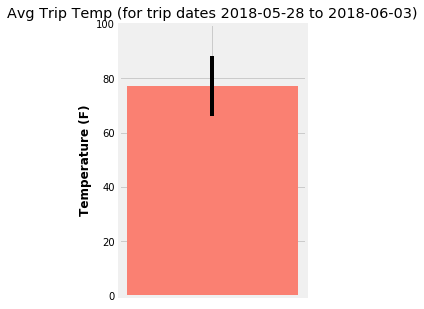

In [30]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title

plt.figure(figsize=(3,5))                                                   
#plt.bar(1, calc_templist[1], yerr=(calc_templist[2] - calc_templist[0]), tick_label='', color='salmon') # plot using list
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
plt.bar(1, mytrip_df['tavg'], yerr=(mytrip_df['tmax'] - mytrip_df['tmin']), tick_label='', color='salmon')
plt.ylabel("Temperature (F)", weight="bold")
plt.ylim(0, 100)  
plt.title("Avg Trip Temp (for trip dates 2018-05-28 to 2018-06-03)")
plt.show()


In [31]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
# My  dates 2018-05-28 to 2018-06-03 , prev year dates dates are '2017-05-28', '2017-06-03
startdate = '2017-05-28'
enddate = '2017-06-03'
rain=session.query(Station.station,Station.name, Station.latitude,Station.longitude,Station.elevation,func.sum(Measurement.prcp),).\
    filter(Measurement.date >= startdate).filter(Measurement.date <= enddate).filter(Measurement.station == Station.station).\
    group_by(Station.station).order_by(func.sum(Measurement.prcp).desc()).all()
rain

[('USC00519281',
  'WAIHEE 837.5, HI US',
  21.45167,
  -157.84888999999998,
  32.9,
  2.02),
 ('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6, 0.94),
 ('USC00514830',
  'KUALOA RANCH HEADQUARTERS 886.9, HI US',
  21.5213,
  -157.8374,
  7.0,
  0.37),
 ('USC00519397',
  'WAIKIKI 717.2, HI US',
  21.2716,
  -157.8168,
  3.0,
  0.32000000000000006),
 ('USC00519523',
  'WAIMANALO EXPERIMENTAL FARM, HI US',
  21.33556,
  -157.71139,
  19.5,
  0.26),
 ('USC00516128',
  'MANOA LYON ARBO 785.2, HI US',
  21.3331,
  -157.8025,
  152.4,
  0.01),
 ('USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9, None)]

,station,name,lat,lng,elevation,total prcp
0,USC00519281,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9,2.02
1,USC00513117,"KANEOHE 838.1, HI US",21.42340,-157.80150,14.6,0.94
2,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0,0.37
3,USC00519397,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0,0.32
4,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5,0.26
5,USC00516128,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4,0.01
6,USC00517948,"PEARL CITY, HI US",21.39340,-157.97510,11.9,NaN


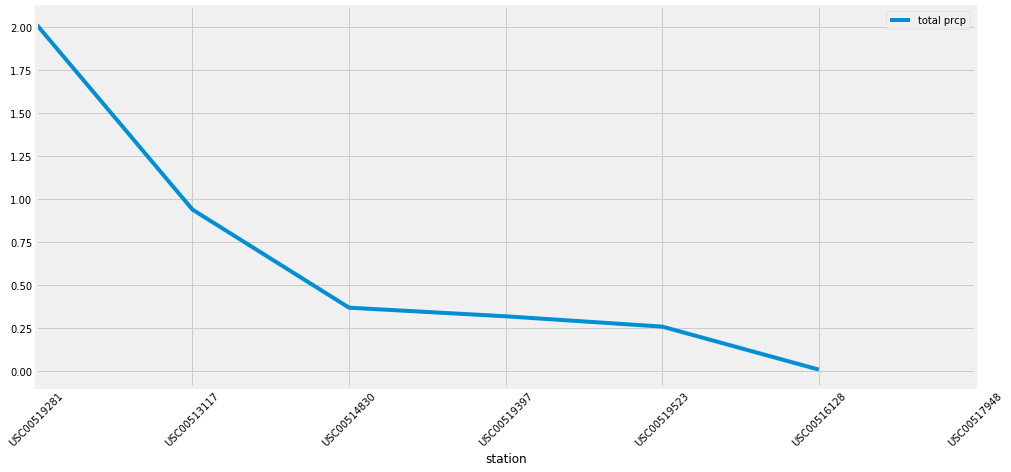

In [32]:
# Display rainfall results in a dataframe
rainfall_df=pd.DataFrame(rain,columns=['station','name','lat','lng','elevation','total prcp'])
rainfall_df.plot(x='station',y='total prcp',figsize=(15, 7),rot=45)
rainfall_df


## Optional Challenge Assignment

In [33]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

## Daily Rainfall Average

In [34]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`
from dateutil import rrule, parser

# Set the start and end date of the trip
# My  dates 2017-05-28 to 2017-06-03 , prev year dates dates are '2017-05-28', '2017-06-03
startdate = '2017-05-28'
enddate = '2017-06-03'

# Use the start and end date to create a range of dates
dates_rng = list(rrule.rrule(rrule.DAILY, dtstart=parser.parse(startdate), until=parser.parse(enddate)))
# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date
d1=list(np.ravel(daily_normals("05-28")))
d2=list(np.ravel(daily_normals("05-29")))
d3=list(np.ravel(daily_normals("05-30")))
d4=list(np.ravel(daily_normals("05-31")))
d5=list(np.ravel(daily_normals("06-01")))
d6=list(np.ravel(daily_normals("06-02")))
d7=list(np.ravel(daily_normals("06-03")))

#dates_rnglist=list(dates_rng)
#dates_rnglist
#d=[]
#for i in dates_rnglist:
 #   d.append(daily_normals(i))
#d




In [35]:
# # Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
cols=['tmin','tavg','tmax']
lists=[cols,d1,d2,d3,d4,d5,d6,d7]
rain_df = pd.DataFrame(lists[1:],columns=lists[0])
rain_df['date']=dates_rng


In [36]:
# convert rain_df['date'] to date format
rain_df['date'] = pd.to_datetime(rain_df.date)
rain_df['date'] =rain_df['date'].dt.date
rain_df=rain_df.set_index('date')
rain_df

,tmin,tavg,tmax
date,,,
2017-05-28,67.0,74.277778,82.0
2017-05-29,64.0,74.196078,80.0
2017-05-30,69.0,74.333333,81.0
2017-05-31,68.0,74.400000,81.0
2017-06-01,64.0,74.614035,81.0
2017-06-02,65.0,74.400000,81.0
2017-06-03,65.0,74.034483,80.0


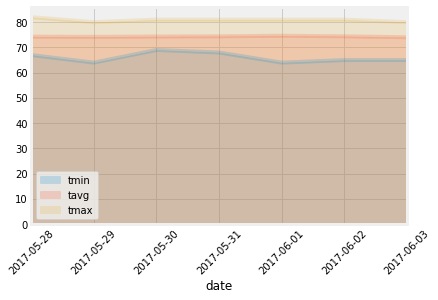

In [37]:
# Plot the daily normals as an area plot with `stacked=False`

ax=rain_df.plot.area(y = ['tmin', 'tavg','tmax'],alpha=0.2,stacked=False,rot=45)
#labels=rain_df['date']
#ax.set_xticklabels(labels,rotation=45)

